# Multi-tissue classification colorectal cancer

**Table of Contents**                                                                      
Step1: Environment Setup                                                                          
Step2: Data Loading and Preparation                                                                      
Step3: Analyzing Class Distribution                                                          
Step4: Data Augmentation for Minority Classes                                                            
Step5: Splitting the Dataset                                                                                     
Step6: Preparing Data Generators                                                             
Step7: Building the Model                                                                                       
Step8: Compiling the Model with Class Weights                                                  
Step9: Implementing Learning Rate Scheduling and Early Stopping                                      
Step10: Training the Model                                                             
Step11: Evaluating the Model                                                                   
Step12: Conclusion and Next Steps                                                           



**Step: 1 Environment Setup**

In [1]:
# Data manipulation and analysis
import os 
import numpy as np
import pandas as pd
from glob import glob

# Image processing
from PIL import Image

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt

**Step 2: Loading Data**


In [2]:
# Assuming the dataset is in a folder named 'dataset'
data_dir = '/kaggle/input/tcga-ovarian-histological-images/ovarian'

# Get class names from subdirectory names
classes = sorted([d.name for d in os.scandir(data_dir) if d.is_dir()])
print("Classes:", classes)


# Initialize lists to hold file paths and labels
image_paths = []
image_labels = []

# Map class names to numerical labels
class_to_label = {class_name: idx for idx, class_name in enumerate(classes)}
print("Class to label mapping:", class_to_label)

# Loop through each class directory and collect file paths
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    # Get all image file paths in the class directory
    image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith('.jpg')]
    # Append file paths and labels
    image_paths.extend(image_files)
    image_labels.extend([class_to_label[class_name]] * len(image_files))
    #print(f"Processing {len(image_files)} images for class '{class_name}'")

print(f"Total images found: {len(image_paths)}")

Classes: ['non-tumour', 'tumour']
Class to label mapping: {'non-tumour': 0, 'tumour': 1}
Total images found: 33110


**3. Analyzing Class Distribution**

Class counts before augmentation:
 class_name
tumour        19747
non-tumour    13363
Name: count, dtype: int64


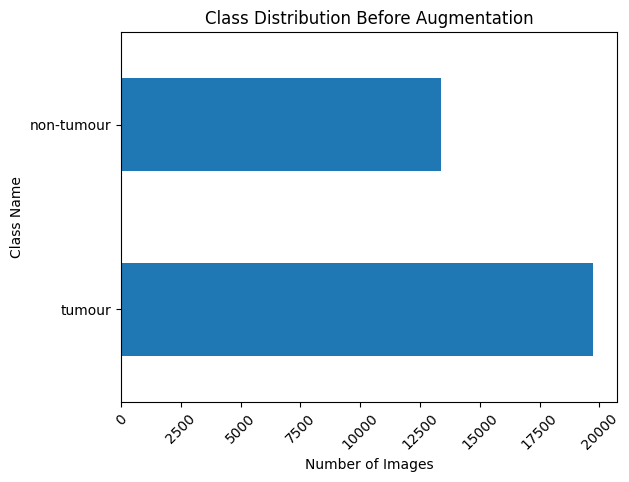

In [3]:
# Create a DataFrame to aid in analysis
df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

# Map numerical labels to class names
label_to_class = {v: k for k, v in class_to_label.items()}
df['class_name'] = df['label'].map(label_to_class)

# Display class counts
class_counts = df['class_name'].value_counts()
print("Class counts before augmentation:\n", class_counts)

# Plot class distribution
class_counts.plot(kind='barh')
plt.title('Class Distribution Before Augmentation')
plt.xlabel('Number of Images')
plt.ylabel('Class Name')
plt.xticks(rotation=45)
plt.show() 

**4. Data Augmentation for Minority Classes**


In [4]:
# Define augmentation parameters
data_gen_args = dict(
    preprocessing_function=preprocess_input,  # Required for VGG
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [5]:
# Define data augmentation transformations
def balanced_data_generator(df, batch_size, target_size, datagen):
    '''
    A generator that yields batches of images and labels, balancing classes by oversampling minority classes.
    '''
    # Get the class counts
    class_counts = df['label'].value_counts()
    max_count = class_counts.max()
    class_indices = {label: df[df['label'] == label].index for label in class_counts.index}

    while True:
        batch_paths = []
        batch_labels = []

        # Oversample minority classes
        for label, indices in class_indices.items():
            num_samples = max_count - len(indices)
            if num_samples > 0:
                extra_indices = np.random.choice(indices, size=num_samples, replace=True)
                indices = indices.union(extra_indices)

            # Shuffle indices
            indices = np.random.permutation(indices)
            batch_paths.extend(df.loc[indices, 'image_path'].tolist())
            batch_labels.extend(df.loc[indices, 'label'].tolist())

        # Combine and shuffle
        combined = list(zip(batch_paths, batch_labels))
        np.random.shuffle(combined)
        batch_paths, batch_labels = zip(*combined)

        # Yield batches
        for i in range(0, len(batch_paths), batch_size):
            batch_end = min(i + batch_size, len(batch_paths))
            batch_images = []
            batch_labels_one_hot = []

            for j in range(i, batch_end):
                # Load and preprocess the image
                img = Image.open(batch_paths[j]).convert('RGB')
                #img = img.resize(target_size)
                img_array = np.array(img)
                batch_images.append(img_array)
                batch_labels_one_hot.append(to_categorical(batch_labels[j], num_classes=len(classes)))

            # Convert lists to arrays
            X_batch = np.array(batch_images)
            y_batch = np.array(batch_labels_one_hot)

            # Apply real-time data augmentation
            augmented_iterator = datagen.flow(X_batch, y_batch, batch_size=batch_size, shuffle=False)
            X_batch_augmented, y_batch_augmented = next(augmented_iterator)

            # Normalize
            X_batch_augmented = X_batch_augmented / 255.0

            yield X_batch_augmented, y_batch_augmented

**Step 5: Split the Dataset**


In [6]:
# Split into training and temp (validation + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Split temp into validation and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")




Training set size: 26488
Validation set size: 3311
Test set size: 3311


**6. Preparing Data Generators**


In [7]:
# Parameters
batch_size = 32
target_size = (224, 224)  
num_classes = len(classes)

# Data generators
# Create an instance of ImageDataGenerator with the defined transformations
datagen = ImageDataGenerator(**data_gen_args)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

6.1. Training Data Generator


In [8]:
# Training generator with balanced batches
train_generator = balanced_data_generator(
    train_df,
    batch_size=batch_size,
    target_size=target_size,
    datagen=datagen
)


# Calculate steps per epoch
#steps_per_epoch = len(train_df) * 2 // batch_size  # Oversampling will effectively double the data

steps_per_epoch = (train_df['label'].value_counts().max() * num_classes) // batch_size


6.2. Validation Data Generator

In [9]:
# Validation data preparation
def prepare_dataset(df):
    images = []
    labels = []

    for idx, row in df.iterrows():
        img = Image.open(row['image_path']).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img)
        images.append(img_array)
        labels.append(row['label'])

    X = np.array(images) / 255.0
    y = to_categorical(labels, num_classes=len(classes))
    return X, y

# Prepare validation and test datasets
X_val, y_val = prepare_dataset(val_df)
X_test, y_test = prepare_dataset(test_df)

print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Validation set shape: (3311, 224, 224, 3), (3311, 2)
Test set shape: (3311, 224, 224, 3), (3311, 2)


**9. Building and Configuring the VGG Model**

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool1 (MaxPooling2D)              │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2 (MaxPooling2D)              │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool3 (MaxPooling2D)              │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avgpool (GlobalAveragePooling2D)     │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,714 (92.63 KB)

 Trainable params: 23,714 (92.63 KB)

 Non-trainable params: 0 (0.00 B)

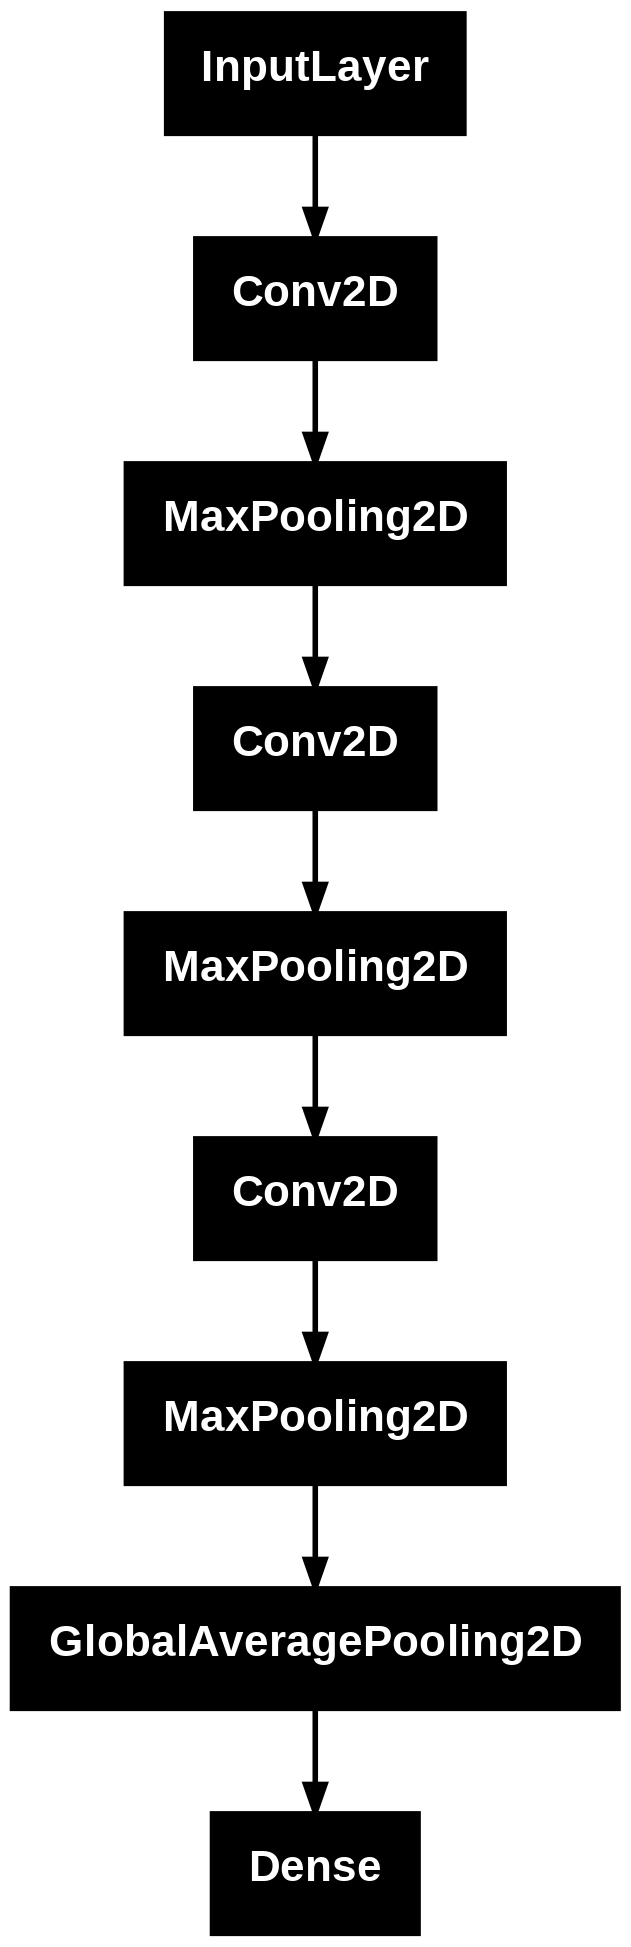

In [17]:


inputs = tf.keras.Input(shape=(224, 224, 3), name='input')

conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, name='conv1')(inputs)
maxpool1 = tf.keras.layers.MaxPooling2D(name='maxpool1')(conv1)

conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, name='conv2')(maxpool1)
maxpool2 = tf.keras.layers.MaxPooling2D(name='maxpool2')(conv2)

conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, name='conv3')(maxpool2)
maxpool3 = tf.keras.layers.MaxPooling2D(name='maxpool3')(conv3)

avgpool = tf.keras.layers.GlobalAveragePooling2D(name='avgpool')(maxpool3)

outputs = tf.keras.layers.Dense(2, activation='softmax', name='output')(avgpool)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()
tf.keras.utils.plot_model(model)



In [18]:
# Compile the model
model.compile(optimizer= 'adam' , loss= tf.keras.losses.binary_crossentropy, metrics=['accuracy']) 

In [19]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,
)

callbacks = [early_stopping, reduce_lr]

Step 7: Cross-validating model        


In [20]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=(X_val, y_val),
    #class_weight=class_weights,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/30
987/987 ━━━━━━━━━━━━━━━━━━━━ 511s 513ms/step - accuracy: 0.8018 - loss: 0.4235 - val_accuracy: 0.4029 - val_loss: 4.0612 - learning_rate: 0.0010
Epoch 2/30
987/987 ━━━━━━━━━━━━━━━━━━━━ 350s 355ms/step - accuracy: 0.8944 - loss: 0.2916 - val_accuracy: 0.4117 - val_loss: 2.7744 - learning_rate: 0.0010
Epoch 3/30
987/987 ━━━━━━━━━━━━━━━━━━━━ 376s 381ms/step - accuracy: 0.9057 - loss: 0.2622 - val_accuracy: 0.4295 - val_loss: 2.5826 - learning_rate: 0.0010
Epoch 4/30
987/987 ━━━━━━━━━━━━━━━━━━━━ 361s 366ms/step - accuracy: 0.9159 - loss: 0.2492 - val_accuracy: 0.4533 - val_loss: 2.4488 - learning_rate: 0.0010
Epoch 5/30
987/987 ━━━━━━━━━━━━━━━━━━━━ 355s 360ms/step - accuracy: 0.9204 - loss: 0.2296 - val_accuracy: 0.6225 - val_loss: 1.1306 - learning_rate: 0.0010
Epoch 6/30
987/987 ━━━━━━━━━━━━━━━━━━━━ 357s 362ms/step - accuracy: 0.9349 - loss: 0.1986 - val_accuracy: 0.8423 - val_loss: 0.4010 - learning_rate: 0.0010
Epoch 7/30
987/987 ━━━━━━━━━━━━━━━━━━━━ 357s 362ms/step - accura

Step 8: Testing model            


In [23]:
# Evaluate the model on the test set
test_steps = len(test_df) // batch_size
test_loss, test_accuracy = model.evaluate(X_test, y_test, steps=test_steps)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9129 - loss: 0.2601
Test Accuracy: 91.33%


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1336
           1       0.93      0.93      0.93      1975

    accuracy                           0.91      3311
   macro avg       0.91      0.91      0.91      3311
weighted avg       0.91      0.91      0.91      3311

Confusion Matrix:
[[1193  143]
 [ 144 1831]]


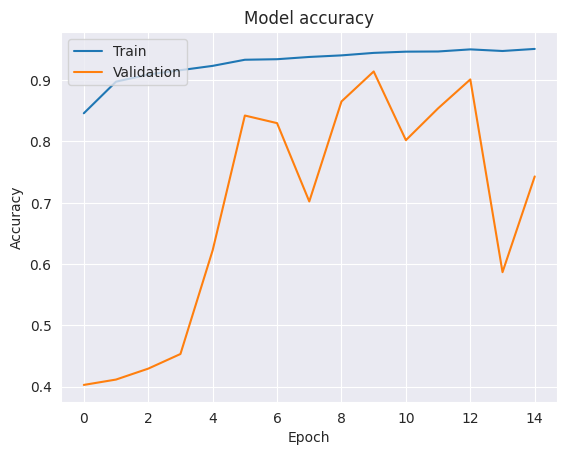

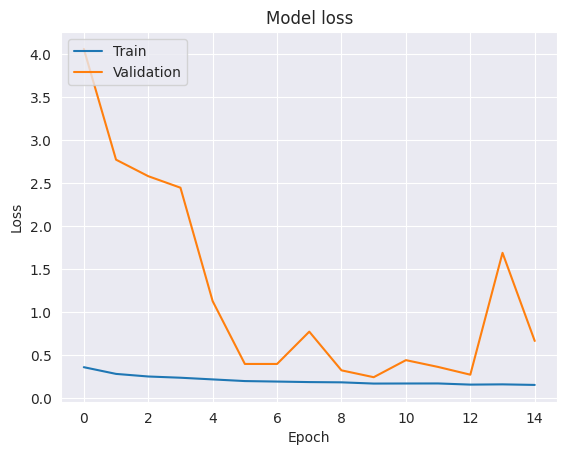

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:
# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')